Packages die zur Erzeugung von Videos benötigt werden.

In [ ]:
!apt-get update
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake
!apt install swig xvfb
!pip install -U setuptools pyvirtualdisplay ez_setup gymnasium gymnasium[box2d]

Helferfunktion zur Erzeugung von Videos.

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

import io
import base64
from IPython import display
from IPython.display import HTML
def embed_video(video_file):
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data)
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))

# **Tutorial**: Einführung in Reinforcement Leraning
Dieses Tutorial ist ein kurze Einführung in *Reinforcement Learning (RL)*. Es wird die Bibliothek [Gymnasium](https://gymnasium.farama.org/) verwenden, eine Fork der ursprünglichen OpenAI-Gym-Bibliothek. Diese Bibliothek bietet eine einheitliche API zur Erstellung und Verwaltung verschiedener RL-Umgebungen.

Gymnasium bietet eine Reihe von vorgefertigten Umgebungen (z.B. einfache 2D-Aufgaben, Atari-Spiele oder Roboter-Simulationen), die direkt in eigenen RL-Experimenten verwendet werden können. Die API ist auch so konzipiert, dass eigenen Umgebungen erweitert oder erstellet werden können.

In diesem Tutorials werden beide *Temporaldifferenz (TD)*-Lernmethoden **Q-Learning** und **SARSA** am Beispiel der **Cliff-Walking**-Umgebung implementieren.

Die [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) ist ein klassisches Grid-World Problem.
Der Agent startet auf einem Feld (S) und soll ein Ziel (G) erreichen, aber dazwischen befindet sich eine Klippe, die eine starke negative Belohnung auslöst, wenn sie betreten wird, und den Agenten zurück an den Start bringt. Damit ist das Szenario ideal, um zu untersuchen, wie verschiedene RL-Methoden (z.B. Q-learning und SARSA) mit riskanten Aktionen und negativen Konsequenzen umgehen.

Q-learning ist eine *off-policy* TD-Methode. Der Agent aktualisiert seine Q-Werte so, als ob er immer einer *greedy*-Policy verfolgen würde, auch wenn er in der Praxis andere Aktionen durchführt (z.B. während der Exploration). Dadurch kann er seine Wertaktualisierung unabhängig von der tatsächlich verwendeten Policy berechnen.

SARSA ist eine *on-policy* TD-Methode. Hier basieren die Q-Wert-Aktualisierungen auf der *tatsächlich* ausgeführten Aktion und der daraus resultierenden Folgeaktion. Das bedeutet, dass der Agent immer aus dem Verhalten lernt, das er gerade zeigt (z. B. einschließlich $\epsilon$-Greedy-Exploration).

Der entscheidende Unterschied zwischen off-policy und on-policy ist also, ob der Algorithmus *unabhängig von* (Q-learning), oder *abhängig von* (SARSA) von der aktuell verwendeten Policy ist.

## **Teil 1:** Gymnasium
Gymnasium ist eine benutzerfreundliche, auf Python basierende Bibliothek, die sich ideal für die Darstellung und Bearbeitung allgemeiner RL-Problemen eignet. Sie bietet eine einheitliche API für Single-Agent-Umgebungen und enthält Implementierungen von gängigen Szenarien wie CartPole, Pendulum, MountainCar, MuJoCo, Atari und vielen anderen.

Im Zentrum von Gymnasium steht die Klasse [Env](https://gymnasium.farama.org/api/env/) - eine High-Level-Python-Klasse, die einen Markov Decision Process (MDP) abbildet. Sie kann verwendet werden, um Anfangszustände zu erzeugen, Aktionen auszuführen und die daraus resultierenden Zustand (Observation) und Belohnungen (Reward) zu beobachten. Darüber hinaus können Environements mit so genannten *Wrappern* flexibel erweitert und angepasst werden, beispielsweise durch Transformation der Beobachtungen, Änderung der Belohnungen oder Modifikation der Aktionen.

Für die [Grundlegende Anwendung](https://gymnasium.farama.org/introduction/basic_usage/) sind die folgenden vier Funktionen wichtig:
*   `make(env_id, ...)`:  Erstellt eine Instanz der gewünschten Umgebung anhand ihrer ID (z. B. `CliffWalking-v0`). Optionale Argumente können etwa das Rendering oder bestimmte Einstellungen betreffen.  
*   `reset()`: Setzt die Environement in ihren Anfangszustand zurück und liefert den ersten Zustand und auch zusätzliche Informationen.  
*   `step(action)`: Führt die angegebene Aktion in der Environement aus und gibt ein Tupel zurück, das u. a. den neune Zustand, die erhaltenen Belohnung, Flags zum Episodenende (terminated, truncated), sowie weiter Informationen enthält.  
*   `close()`: Schließt die Umgebung und gibt alle eventuell belegten Ressourcen (z. B. Grafiken, Fenster) frei.


In [ ]:
# Importiere das Gymnasium-Modul sowie den RecordVideo-Wrapper zur Videoaufzeichnung
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

**Aufgabe 1.1: Umgebung Initialisierung**

Initialisiere die Cliff-Walking-Umgebung mit dem Namen `env` und setze  `render_mode='rgb_array'`, sowie  `max_episode_steps=100`. In diesem Render Mode stellt die Umgebung Bilddaten (rgb_array) zur Verfügung stellt, die sich für die spätere Videoerzeugung eignen. Der Parameter `max_episode_steps` legt fest, wie viele Aktionen (Schritte) maximal in einer Episode ausgeführt werden dürfen, bevor die Umgebung automatisch beendet wird.

Speichere die Größe des Zustandsraum (Anzahl an möglichen Zustände) in der Variable `num_obs` und die Größe des Aktionsraum (Anzahl an möglichen Aktionen) in der Variable `num_actions`.

Gib die Beschreibungen des Zustandraum (Observation Space) und des Aktionsraum (Action Space) auf der Konsole aus.

In [ ]:
# Aufgabe 1.1

**Aufgabe 1.2: RL-Loop und Videoaufzeichnung**

Um deine Interaktionen aufzuzeichnen, wrappe `env` in `RecordVideo`. Dabei muss der Pfad, in dem das Video gespeichert werden soll, z. B. `'./rl_video/a12'` mit übergeben werden.

Implementiere den typischen RL-Loop:
1.   Setze die Umgebung mit `eval_env.reset()` zurück, um den Startzustand zu erhalten
2. Führe in einer Schleife solange zufällige Aktionen aus, bis die Episode (das Spiel) endet. Für die Auswahl einer zufälligen Aktion kann `env.action_space.sample()` verwendet werden.
3. Beende die Schleife, wenn `terminated` oder `truncated` zurückgegeben wird
4. Schließe die Umgebung, damit alle Ressourcen freigegeben werden und das Video abgeschlossen wird.
   
Mithilfe der Funktion `embed_video('rl_video/a12/rl-video-episode-0.mp4')` kann das Video direkt im Notebook anzeigt werden.

In [ ]:
# Aufgabe 1.2

## **Teil 2:** Q-Learning
Q-Learning ist ein off-policy Temporal-Difference-Verfahren, d.h. der Agent kann seine Policy unabhängig davon verbessern, welche Aktionen in der Umgebung tatsächlich ausprobiert werden. Konkret lernt der Agent eine sogenannte *Q-Tabelle*, in der jeder Zustands-Aktions-Kombination (State-Action-Paar) ein Wert (Q-Wert) zugewiesen wird. Dieser Q-Wert gibt an, wie vorteilhaft eine Aktion in einem bestimmten Zustand auf lange Sicht ist.

### Q-Tabelle und Bellman-Gleichung
Die *Q-Tabelle* speichert einen Schätzwert $Q(s, a)$ für jeden Zustand $s$ und jede mögliche Aktion $a$. Dieser Wert wird iterativ mit Hilfe der Bellman-Gleichung aktualisiert. Die Aktualisierungsregel für das Q-Lernen lautet:

$Q(s, a) \leftarrow Q(s, a) \;+\; \alpha \bigl[R + \gamma \max_{a'} Q(s', a') - Q(s, a)\bigr]$

- $\alpha$ ist die *Lernrate*, die bestimmt, wie viel neue Erfahrung in die Q-Werte eingeht.  
- $\gamma$ ist der *Diskontfaktor*, der bestimmt, wie stark zukünftige Belohnungen berücksichtigt werden.  
- $R$ ist die sofortige Belohnung, die durch das Ausführen der Aktion $a$ in Zustand $s$ erhalten wird.    
- $\max_{a'} Q(s', a')$ ist der höchste geschätzte Q-Wert für alle möglichen Aktionen $a'$ im Folgezustand $s'$.

#### Q-Learning Pseudocode
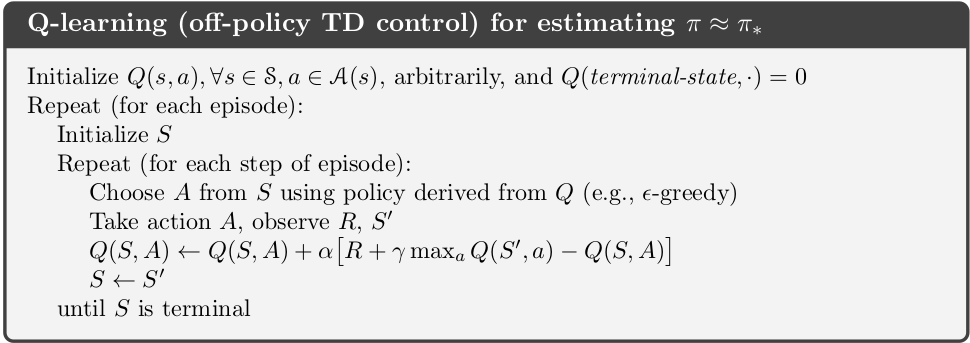


### $\epsilon$-Greedy Exploration
Eine $\epsilon$-greedy policy wird verwendet, um neues Verhalten zu erforschen (Exploration) und um gelernte Polieices auszunutzen (Exploitation). Das bedeutet, dass:
- Mit Wahrscheinlichkeit $1 - \epsilon$ (z. B. 90 %) wird die Aktion mit dem höchsten Q-Wert (gierige Aktion) gewählt.  
- Mit der Wahrscheinlichkeit $\epsilon$ (z.B. 10%) wird eine Aktion zufällig ausgewählt, um die Umgebung weiter zu erkunden.

Auf diese Weise kann der Agent verhindern, dass er zu schnell in lokale Optima gerät und neue Zustände oder Aktionen vernachlässigt.


In [ ]:
# NumPy ist ein Paket für numerische Berechnungen in Python
import numpy as np

**Aufgabe 2.1: Q-Tabelle erstellen**.

Initialisiere ein NumPy-Array `Q1` mit [Nullen](https://numpy.org/devdocs/reference/generated/numpy.zeros.html). In dieser Tabelle werden später deine Q-Werte eingetragen und aktualisiert.  

Eine Q-Tabelle `Q1` ist nichts anderes als ein 2D-Array (Matrix) mit `num_obs` Zeilen (je eine pro Zustand) und `num_actions` Spalten (je eine pro Aktion).  




In [ ]:
# Aufgabe 2.1

**Aufgabe 2.2: $\epsilon$-greedy Funktion implementieren**

Deklariere eine Funktion `epsilon_greedy(Q, obs, epsilon)`.  
Erzeuge einen [Zufallswert](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.random.html) zwischen 0 und 1.  
- Falls dieser Zufallswert kleiner als $\epsilon$ ist, soll eine zufällige Aktion (aus allen möglichen `num_actions`) gewählt werden.  
- Ansonsten wähle die Aktion die für den Zustand `obs` den [höchsten Q-Wert](https://numpy.org/doc/2.2/reference/generated/numpy.argmax.html) aufweist.  

In [ ]:
# Aufgabe 2.2

**Aufgabe 2.3: Q-Learning implementieren**
*   Erstelle eine neue Cliff Walking Umgebung mit `render_mode=None` für effizienteres Training.
* Verwende die zuvor erstellte Q-Tabelle (`Q1`).  
*   Durchlaufe in einer Schleife `num_episodes` Episoden.  
*   In jeder Episode
      1.   Setze die Umgebung zurück, um einen Anfangszustand `obs` zu bekommen.
      2.   Wähle eine Aktion mittels `epsilon_greedy(Q1, obs, epsilon)`, um Exploration und Exploitation zu kombinieren.  
      3.   Führe die Aktion in der Umgebung aus (`env.step(action)`) und beobachte den Folgezustand `next_obs`, die Belohnung `reward` sowie den Episodenstatus (`terminated`/`truncated`)
      4.    Führe TD-Schritt anhand der Q-Learning-Formel aus:
$Q(s, a) ← Q(s, a) \;+\; \alpha \bigl[R + \gamma \max_{a'} Q(s', a') - Q(s, a)\bigr]$
      5.    Beende die Episode, wenn `terminated` oder `truncated` gesetzt sind.
* Sammle in die Gesamtbelohnung jede Episode in der Liste `reward` (`reward.append(total_reward)`)
   

In [ ]:
# Lernrate (gibt an, wie stark neue Erfahrungen in das Q-Update einfließen)
alpha = 0.2
# Discount-Faktor (bestimmt, wie stark zukünftige Belohnungen berücksichtigt werden)
gamma = 0.99
# Explorationsrate (Legt fest, wie häufig zufällige Aktionen ausgeführt werden)
epsilon = 0.1
# Anzahl der Trainings-Episoden
num_episodes = 250
# Liste der Gesamt-Belohnungen einer Epsiode
rewards = []

In [ ]:
# Aufgabe 2.3

In [ ]:
# Zeigt die Gesamtbelohnung pro Episode in einem Diagramm
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q-Learning: Verlauf der Episoden-Belohnungen')
plt.tight_layout()
plt.show()

**Aufgabe 2.4: Ausführen der gelernten Q-Learning Policy und Videoaufzeichnung**

Erzeuge dazu eine neue Cliff-Walking-Umgebung über `gym.make('CliffWalking-v0', render_mode='rgb_array')` und nutze den `RecordVideo`-Wrapper für die Umgebung, z. B. mit dem Pfad `'./rl_video/a24'`. Setze die Umgebung zurück und führe eine Episode aus.
Verwende *keine* Exploration mehr, sondern wähle ausschließlich die beste die Aktion. Schließe nach Ende der Episode die Umgebung, damit das Video korrekt beendet wird. Bette das entstandene Video mithilfe von `embed_video('...')` in das Notebook ein.

## **Teil 3:** SARSA
SARSA ist ein *on-policy* Temporal-Difference-Verfahren. Das bedeutet, dass der Agent seine Q-Werte genau auf der Grundlage der von ihm tatsächlich durchgeführten Aktionen aktualisiert. Dieser Ansatz steht im Gegensatz zum Q-Lernen (*off-policy*), bei dem die Aktualisierung so durchgeführt wird, als ob der Agent immer die beste Aktion wählt - unabhängig von der tatsächlichen Policy während der Exploration.

### Aktionswahl und Bellman-Update
In SARSA wählt der Agent eine Aktion $a$ im aktuellen Zustand $s$ gemäß seiner $\epsilon$-greedy Policy. Nachdem er die Belohnung $R$ erhalten und den Folgezustand $s'$ erreicht hat, wählt er *direkt* wieder eine Aktion $a'$ in $s'$ - ebenfalls gemäß derselben $\epsilon$-greedy Policy. Der Hauptunterschied zum Q-Lernen besteht darin, dass der Aktualisierungsschritt nicht $\max\bigl(Q(s',\cdot)\bigr)$ verwendet, sondern genau den Q-Wert der tatsächlich im Zustand $s'$ gewählten Aktion $a'$. Die Q-Tabelle $Q$ wird mit aktualisiert:

$Q(s, a) \; \leftarrow \; Q(s, a) \;+\; \alpha \Bigl[\, R + \gamma \, Q(s', a') - Q(s, a) \Bigr]$

#### SARSA Pseudocode
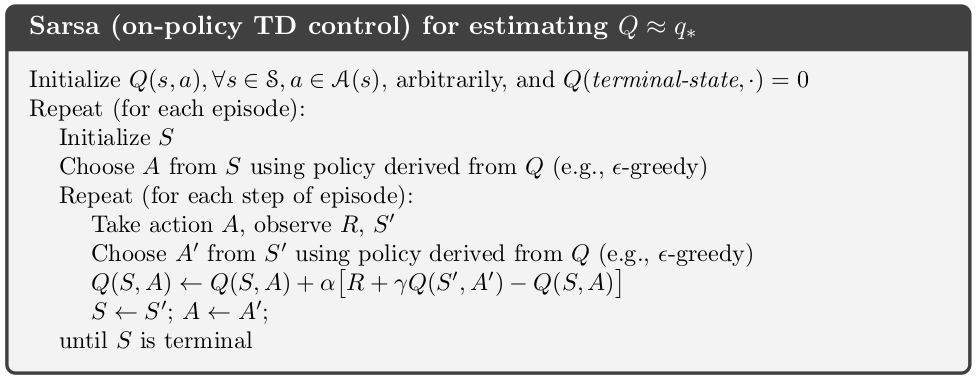

Da SARSA das tatsächliche Verhalten des Agenten widerspiegelt, führt eine hohe $\epsilon$-Rate (häufige Zufallshandlungen) automatisch zu einem „vorsichtigeren“ Lernverhalten. Indem die lernende Policy mit der Ausführungspolitik identisch ist, vermeidet man, dass der Agent Annahmen über Aktionen macht, die er in der Realität nicht (oder nur selten) ausführt.

**Aufgabe 3.1: SARSA implementieren**
* Erzeuge eine neue Cliff-Walking-Umgebung (mit `render_mode=None` für effizienteres Training)  
* Initialisiere eine neue Q-Tabelle `Q2` mit Nullen (analog zu Q-Learning)  
* Durchlaufe in einer Schleife `num_episodes` Episoden.  
* In jeder Episode  
   1. Setze die Umgebung zurück, um einen Anfangszustand `obs` zu erhalten.  
   2. Wähle sofort eine erste Aktion $\epsilon$-greedy (`epsilon_greedy(Q2, obs, epsilon)`).  
   3. Führe die Aktion in der Umgebung aus und erhalte den Folgezustand `next_obs`, die Belohnung `reward` sowie den Episodenstatus (`terminated` oder `truncated`).  
   4. Wähle im Folgezustand `next_obs` erneut $\epsilon$-greedy eine neue Aktion `next_action`.  
   5. Führe TD-Schritt anhand der SARSA-Formel aus:  
$Q(s, a) \; \leftarrow \; Q(s, a) \;+\; \alpha \Bigl[\, R \;+\; \gamma\,Q(s', a') \;-\; Q(s, a)\Bigr].$  
   6. Aktualisiere den Zustand und die Aktion
   7. Beende die Episode, sobald `terminated` oder `truncated` erreicht ist.  
* Sammle in die Gesamtbelohnung jede Episode in der Liste `reward` (`reward.append(total_reward)`)


In [ ]:
# Aufgabe 3.1

In [ ]:
# Zeigt die Gesamtbelohnung pro Episode in einem Diagramm
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('SARSA: Verlauf der Episoden-Belohnungen')
plt.tight_layout()
plt.show()

**Aufgabe 3.2: Ausführen der gelernten SARSA Policy und Videoaufzeichnung**

Erzeuge dazu eine neue Cliff-Walking-Umgebung über `gym.make('CliffWalking-v0', render_mode='rgb_array')` und nutze den `RecordVideo`-Wrapper für die Umgebung, z. B. mit dem Pfad `'./rl_video/a32'`. Setze die Umgebung zurück und führe eine Episode aus.
Verwende *keine* Exploration mehr, sondern wähle ausschließlich die beste die Aktion. Schließe nach Ende der Episode die Umgebung, damit das Video korrekt beendet wird. Bette das entstandene Video mithilfe von `embed_video('...')` in das Notebook ein.



In [ ]:
# Aufgabe 3.2